# Red neuronal recurrente para el reconocimiento de comandos de voz


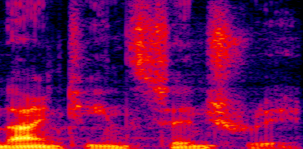

El objetivo de esta actividad es conocer cómo una red neuronal recurrente puede aplicarse en el desarrollo de un modelo para el reconocimiento de comandos de voz. Para este ejemplo, se propone aplicar la transformada de Fourier para obtener el espectro de una señal de audio. En particular utilizaremos la Short Time Fourier Transform para obtener un espectrograma (representación visual que nos permita ver las frecuencias en el tiempo y la magnitud de la onda como color).


In [ ]:
# Conjunto de comandos de voz para el entrenamiento, validación y pruebas

!unzip '/content/drive/MyDrive/AM2024o/examples/command-recognition/mv_commands.zip' -d '/content/drive/MyDrive/AM2024o/examples/command-recognition'

## Visualización de audio

En este ejemplo, veamos como visualizar un canal de una señal de audio. Para esto, utilizaremos **tf.io.read_file** para cargar a memoria el contenido de un archivo de audio, **tf.audio.decode_wav** para decodificar el contenido del archivo (bytes) e interpretarlo como el contenido de un archivo de audio en formato **wav**. Al decodificar el archivo de audio obtendremos:
- Una o más secuencias de valores escalares (muestras que representan la magnitud o amplitud de la onda). El número de secuencias depende del número de canales utilizados para grabar el audio (por ejemplo, mono, estereo, etc.).
- La frecuencia de muestreo a la cual se grabo el audio.

Una vez que tenemos las secuencias de valores escalares, podemos visualizar la secuencia mediante el uso de **plt.plot**

Analiza y ejeucta la siguiente celda, verifica cuantas secuencias retorna **decode_wav** y la frecuencia de muestre con la que fue grabado el audio.

nota: observa que en este ejemplo se gráfica únicamente la onda sorrespondiente  a un canal.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_audio(filepath):

  #Cargar el archivo binario
  audio_binary=tf.io.read_file(filepath)

  # Decodificar el contenido del archivo binario
  # Secuencia de escalares (magnitudes) y frecuencia de muestreo
  audio, audioSR = tf.audio.decode_wav(audio_binary)

  # Trabajaremos con un eje (matriz a vector)
  audio = tf.squeeze(audio, axis=-1)

  t = np.arange(0, len(audio))
  plt.plot(t, audio, 'g')
  plt.show()

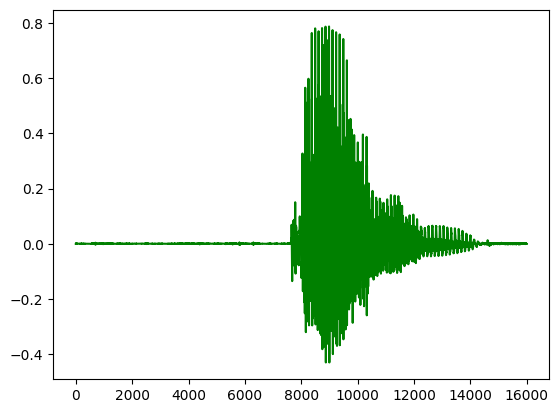

In [4]:
filepath='/content/drive/MyDrive/AM2024o/examples/command-recognition/mv_commands/down/00176480_nohash_0.wav'
plot_audio(filepath)

## Reproducción de audio

Veamos cómo reproducir un archivo de audio utilizando **Audio** y **display** del módulo **display** de **IPython**. Existen diversas librerías que podemos utilizar para la reproducción de audio, te invito a explorar y comparar.

In [5]:
from IPython.display import Audio, display

def play_audio(filepath):

  #Cargar el archivo binario
  audio_binary=tf.io.read_file(filepath)

  # Decodificar el contenido del archivo binario
  # Secuencia de escalares (magnitudes) y frecuencia de muestreo
  audio, audioSR = tf.audio.decode_wav(audio_binary)

  audio = tf.squeeze(audio, axis=-1)

  # Obtenemos una secuencia de valores escalares
  sr = tf.get_static_value(audioSR)

  # Es importante considerar que rate debe ser igual a la frecuencia utilizada en la grabación del audio
  display(Audio(audio, rate=audioSR, autoplay=False))

In [6]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
play_audio('/content/drive/MyDrive/AM2024o/examples/command-recognition/mv_commands/down/00176480_nohash_0.wav')

## Uso de STFT (Short Time Fourier Transform) para obtener los espectros de frecuencia y magnitudes

La transformada de Fourier de tiempo corto (STFT) es una técnica que analiza cómo cambia el contenido de frecuencia de una señal a lo largo del tiempo.

En la siguiente celda, podrás observar cómo podemos crear un espectrograma de la señal de audio utilizando STFT. Esto es, una representación visual que nos permite tener información sobre las frecuencias en el tiempo y la magnitud de la onda como color en una imagen.

In [7]:
import tensorflow as tf
import numpy as np

def audioToTensor(filepath):
  #Cargar el archivo binario
  audio_binary=tf.io.read_file(filepath)

  # Decodificar el contenido del archivo binario
  # Secuencia de escalares (magnitudes) y frecuencia de muestreo
  audio, audioSR = tf.audio.decode_wav(audio_binary)

  audio = tf.squeeze(audio, axis=-1)
  sr = tf.get_static_value(audioSR)

  # Longitud máxima de las secuencias de entrada
  # si sample rate = 16000, la logitus máxima sería: 16000*4 (audioSR * seg_len_max)
  # 4 segundos de datos

  seg_len_max=4
  if len(audio) <  audioSR*seg_len_max:
    #Apliquemos un padding
    audio = tf.concat([np.zeros([int(audioSR*seg_len_max)-len(audio)]), audio], 0)
  else:
    #Trunquemos la secuencia de datos acorde a la longitud máxima
    audio = audio[-int(audioSR*seg_len_max):]

  #frame_length nos permite definir el tamaño de la venta
  #frame_step nos permite indicar el número de desplazamientos dela venta
  spectro = tf.signal.stft(audio, frame_length=512, frame_step=128)  #Genera el espectrograma (nuestra secuencia de entrada al modelo)
  spectro = tf.abs(spectro)
  return spectro

In [8]:
s = audioToTensor('/content/drive/MyDrive/AM2024o/examples/command-recognition/mv_commands/down/00176480_nohash_0.wav')

In [9]:
print(s.shape)

(497, 257)


## Visualizar el espectrograma

In [10]:
def plot_spectrogram(spectrogram):
  h = spectrogram.shape[0]
  w = spectrogram.shape[1]
  spec_log = np.log(tf.transpose(spectrogram) + np.finfo(float).eps)
  plt.xlabel("Tiempo")
  plt.ylabel("Frecuencia")
  plt.pcolormesh(range(h), range(w), spec_log)
  plt.show()

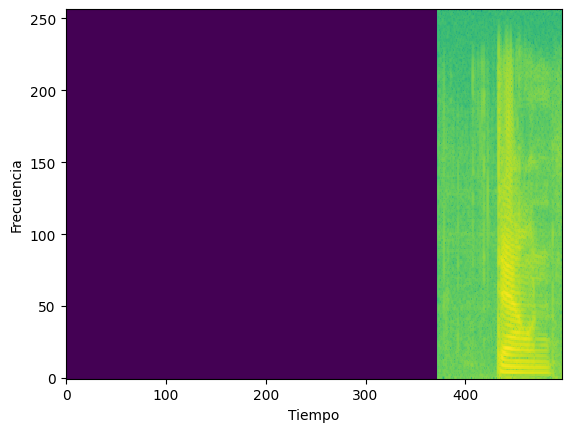

In [11]:
plot_spectrogram(s)

## Crear generador de datos

Es momento de crear el generador de datos, analicemos la siguiente celda y verifiquemos el shape de los tensores: X, Y.

In [12]:
# Crear las listas archivos de audio y su etiqueta correspondiente

from tensorflow.keras.utils import to_categorical
import glob
import os

def getExamples(datafolder):
  X_audio = []
  Y_command = []

  # Comandos
  commands = [os.path.basename(x) for x in glob.glob(datafolder + '*')]
  for i, command in enumerate(commands):
    for file in glob.glob(os.path.join(datafolder, command) + '/*.wav'):
      X_audio.append(file)
      Y_command.append(np.array(to_categorical(i, num_classes=len(commands))))
  return np.asarray(X_audio), np.asarray(Y_command)

In [17]:
# Verifiquemos la implementación de la función y generemos nuestra lista de ejemplos

datafolder= '/content/drive/MyDrive/AM2024o/examples/command-recognition/mv_commands/'
X_audio, Y_command = getExamples(datafolder)

In [18]:
print(X_audio.shape, Y_command.shape)

(21315,) (21315, 9)


In [19]:
# Generemos nuestros datasets de entrenamiento y validación

from sklearn.model_selection import train_test_split

X_audio, X_audio_test, Y_command, Y_command_test = train_test_split(X_audio, Y_command, test_size=0.25)
print(len(X_audio))
print(len(X_audio_test))

15986
5329


In [20]:
#Verifiquemos el contenido de nuestro ejemplo 0
print(X_audio[0], Y_command[0])

/content/drive/MyDrive/AM2024o/examples/command-recognition/mv_commands/on/857366dd_nohash_1.wav [0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [21]:
# Es momento de implementar nuestro generador de Datos
# En esta ocación veamos cómo podemos utilizar Sequence para construir nuestro
# generador de batch de datos

class MySequence(tf.keras.utils.Sequence):

  def __init__(self, x_audio, y_command, batch_size):
    self.x_audio = x_audio
    self.y_command = y_command
    self.batch_size = batch_size

  def __len__(self):
    return len(self.x_audio)//self.batch_size

  def __getitem__(self, idx):
    batch_y = self.y_command[idx * self.batch_size : (idx+1)*self.batch_size]
    batch_x = np.zeros((self.batch_size, s.shape[0], s.shape[1]))
    for i in range(0, self.batch_size):
      batch_x[i] = audioToTensor(self.x_audio[idx * self.batch_size + i])
    return batch_x, batch_y

In [22]:
# Probemos nuestro generador y verifiquemos la forma de los datos de entrada y la salida esperada

mS=MySequence(X_audio, Y_command, 32)
i=iter(mS)
bx, by = next(i)
print(bx.shape, by.shape)

(32, 497, 257) (32, 9)


# Construcción de la red neuronal recurrente

In [23]:
# Ejemplo de modelo basado en redes neuronales recurrentes

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, Dense, Conv2D, BatchNormalization, Reshape
from tensorflow.keras.layers import MaxPooling2D, Dropout, Flatten, TimeDistributed

split_vec=7

input_tensor = Input(shape=(497, 257))
x = BatchNormalization()(input_tensor)
xs = Reshape((x.shape[1]//split_vec, -1, x.shape[2], 1))(x)

xt =TimeDistributed(Conv2D(34, 3, activation='relu'))(xs)
xt =TimeDistributed(Conv2D(64, 3, activation='relu'))(xt)

xt = TimeDistributed(MaxPooling2D())(xt)
xt = TimeDistributed(Dropout(0.25))(xt)
xt = TimeDistributed(Flatten())(xt)

x = LSTM(units=512, return_sequences=False)(xt)
output_tensor = Dense(4, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 497, 257)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 497, 257)            │           1,028 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 71, 7, 257, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 71, 5, 255, 34)      │             340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 71, 3, 253, 64)      │          19,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 71, 1, 126, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 71, 1, 126, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 71, 8064)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 512)                 │      17,565,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,588,764 (67.10 MB)

 Trainable params: 17,588,250 (67.09 MB)

 Non-trainable params: 514 (2.01 KB)